In [1]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report, roc_curve, auc)
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 1. Load dan Eksplorasi Data
def load_data():
    # Download dataset dari: https://www.kaggle.com/datasets/blastchar/telco-customer-churn
    df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

    print("\n=== Informasi Dataset ===")
    print(f"Jumlah baris: {df.shape[0]}, Jumlah kolom: {df.shape[1]}")
    print("\n5 data pertama:")
    print(df.head())

    print("\n=== Statistik Deskriptif ===")
    print(df.describe())

    print("\n=== Distribusi Churn ===")
    print(df['Churn'].value_counts(normalize=True))

    return df

In [3]:
# 2. Preprocessing Data
def preprocess_data(df):
    # Konversi TotalCharges ke numeric dan handle missing values
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df['TotalCharges'].fillna(0, inplace=True)

    # Drop customerID karena tidak relevan untuk modeling
    df.drop('customerID', axis=1, inplace=True)

    # Encode target variable
    df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

    # Identifikasi kolom kategorikal
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

    # One-hot encoding untuk kolom kategorikal
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

    return df

In [4]:
# 3. Visualisasi Data
def visualize_data(df):
    # Visualisasi distribusi churn
    plt.figure(figsize=(8, 5))
    sns.countplot(x='Churn', data=df)
    plt.title('Distribusi Customer Churn')
    plt.show()

    # Visualisasi hubungan antara tenure dan churn
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Churn', y='tenure', data=df)
    plt.title('Hubungan Tenure dengan Churn')
    plt.show()

    # Visualisasi hubungan antara MonthlyCharges dan churn
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
    plt.title('Hubungan Monthly Charges dengan Churn')
    plt.show()

In [5]:
# 4. Modeling dan Evaluasi
def train_and_evaluate(X_train, X_test, y_train, y_test):
    # Inisialisasi model
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42),
        'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
    }

    results = {}

    for name, model in models.items():
        print(f"\n=== Training {name} ===")

        # Training model
        model.fit(X_train, y_train)

        # Prediksi
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Evaluasi
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)

        # Classification report
        cr = classification_report(y_test, y_pred)

        # Cross validation score
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')

        # Simpan hasil
        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc,
            'cv_mean_auc': np.mean(cv_scores),
            'cv_std_auc': np.std(cv_scores),
            'confusion_matrix': cm,
            'classification_report': cr
        }

        # Print hasil
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print(f"ROC AUC: {roc_auc:.4f}")
        print(f"CV Mean AUC: {np.mean(cv_scores):.4f} (±{np.std(cv_scores):.4f})")
        print("\nClassification Report:")
        print(cr)

        # Plot ROC Curve
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {name}')
        plt.legend(loc="lower right")
        plt.show()

    return results

In [6]:
# 5. Feature Importance
def plot_feature_importance(model, feature_names, model_name):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0])
    else:
        print("Model tidak memiliki feature importance atau coefficients.")
        return

    # Buat DataFrame untuk visualisasi
    feature_imp = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False).head(15)

    # Plot
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_imp)
    plt.title(f'Feature Importance - {model_name}')
    plt.show()

    return feature_imp

In [7]:
# 6. Rekomendasi Strategi Retensi
def generate_recommendations(feature_imp):
    print("\n=== Rekomendasi Strategi Retensi Berdasarkan Analisis ===")

    recommendations = []

    # Analisis berdasarkan feature importance
    for feature in feature_imp['Feature'].head(5):
        if 'tenure' in feature:
            recommendations.append("1. Berikan insentif khusus untuk pelanggan baru (tenure rendah) karena mereka lebih rentan churn")
        elif 'MonthlyCharges' in feature:
            recommendations.append("2. Tawarkan paket dengan harga lebih kompetitif untuk pelanggan dengan MonthlyCharges tinggi")
        elif 'Contract' in feature:
            recommendations.append("3. Dorong pelanggan untuk beralih dari kontrak bulanan ke kontrak tahunan dengan memberikan diskon")
        elif 'OnlineSecurity' in feature:
            recommendations.append("4. Tingkatkan penawaran layanan OnlineSecurity karena pelanggan tanpa layanan ini lebih mungkin churn")
        elif 'TechSupport' in feature:
            recommendations.append("5. Perbaiki layanan TechSupport karena ketiadaannya meningkatkan risiko churn")

    # Rekomendasi umum
    recommendations.extend([
        "6. Lakukan program loyalitas untuk meningkatkan engagement pelanggan",
        "7. Identifikasi pelanggan berisiko tinggi secara proaktif dan tawarkan solusi khusus",
        "8. Tingkatkan kualitas layanan pelanggan untuk mengurangi keluhan"
    ])

    for i, rec in enumerate(recommendations, 1):
        print(f"{i}. {rec}")


[1/5] Memuat dataset...

=== Informasi Dataset ===
Jumlah baris: 7043, Jumlah kolom: 21

5 data pertama:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber opt

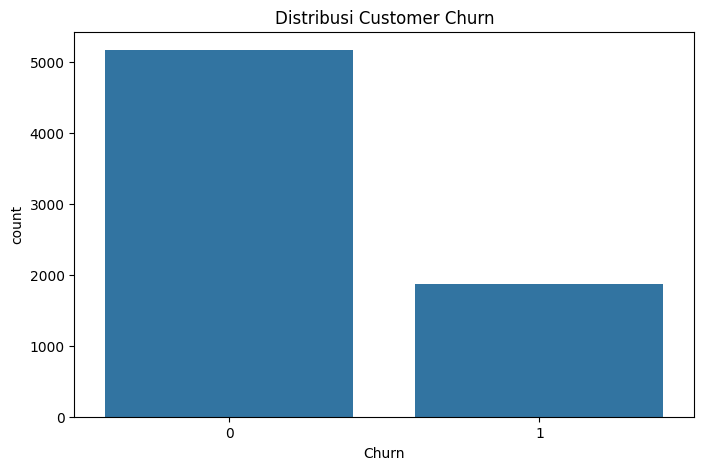

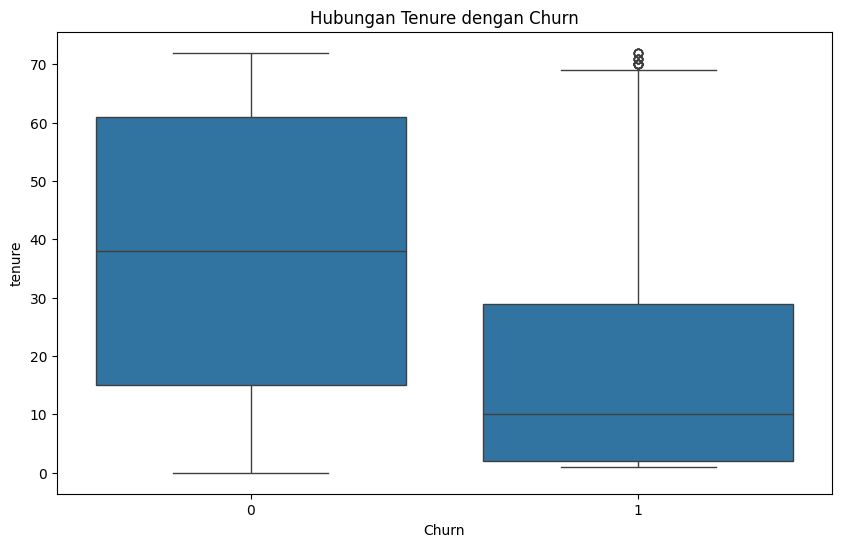

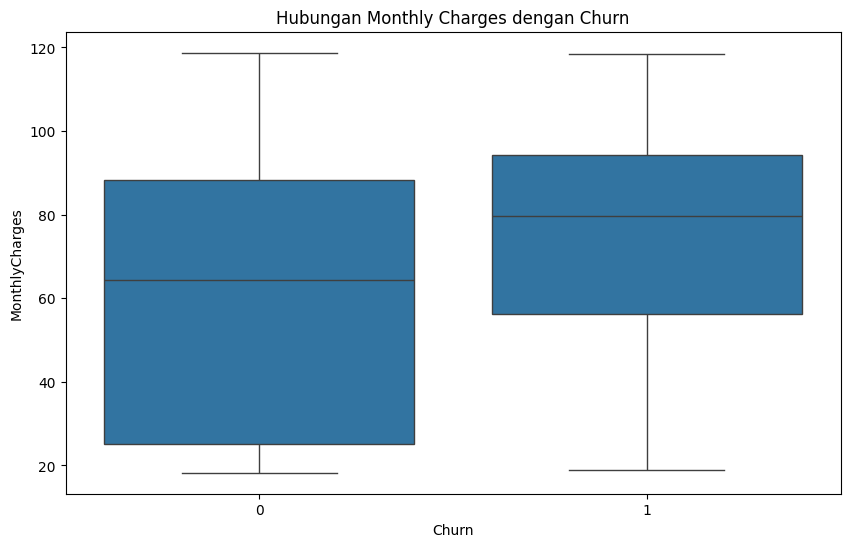


[4/5] Melatih dan mengevaluasi model...

=== Training Logistic Regression ===
Accuracy: 0.8097
Precision: 0.6688
Recall: 0.5615
F1-Score: 0.6105
ROC AUC: 0.8449
CV Mean AUC: 0.8457 (±0.0119)

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1552
           1       0.67      0.56      0.61       561

    accuracy                           0.81      2113
   macro avg       0.76      0.73      0.74      2113
weighted avg       0.80      0.81      0.80      2113



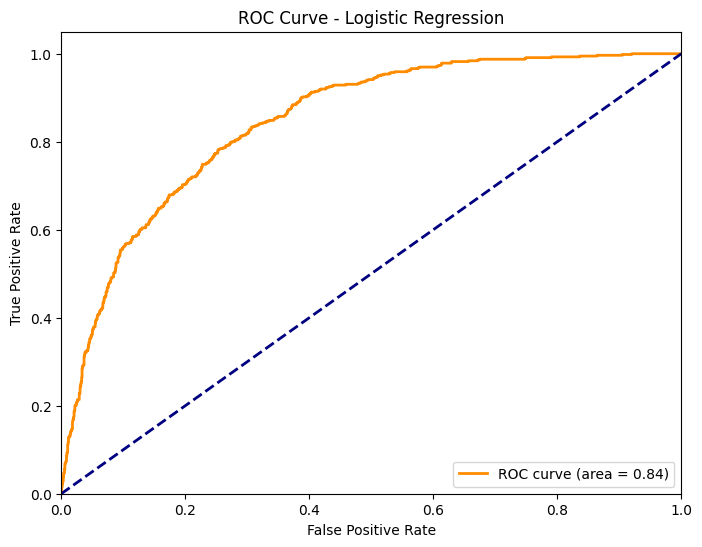


=== Training Random Forest ===
Accuracy: 0.7861
Precision: 0.6236
Recall: 0.4902
F1-Score: 0.5489
ROC AUC: 0.8159
CV Mean AUC: 0.8289 (±0.0145)

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1552
           1       0.62      0.49      0.55       561

    accuracy                           0.79      2113
   macro avg       0.73      0.69      0.70      2113
weighted avg       0.77      0.79      0.78      2113



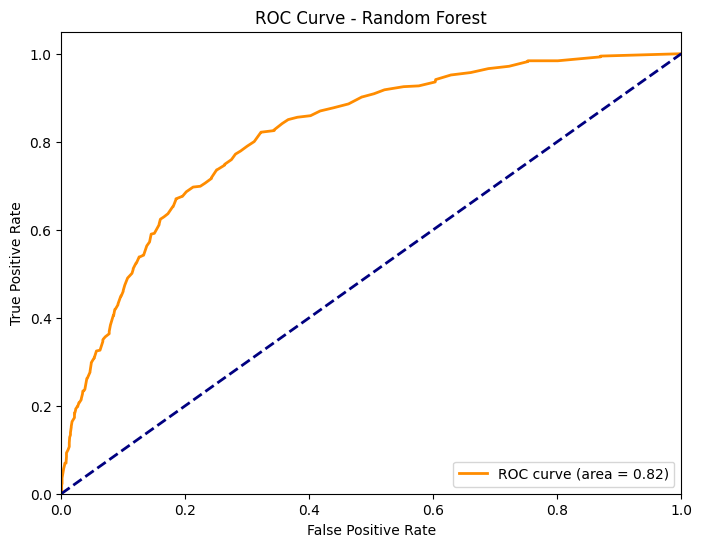


=== Training XGBoost ===
Accuracy: 0.7870
Precision: 0.6168
Recall: 0.5223
F1-Score: 0.5656
ROC AUC: 0.8150
CV Mean AUC: 0.8240 (±0.0179)

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1552
           1       0.62      0.52      0.57       561

    accuracy                           0.79      2113
   macro avg       0.73      0.70      0.71      2113
weighted avg       0.78      0.79      0.78      2113



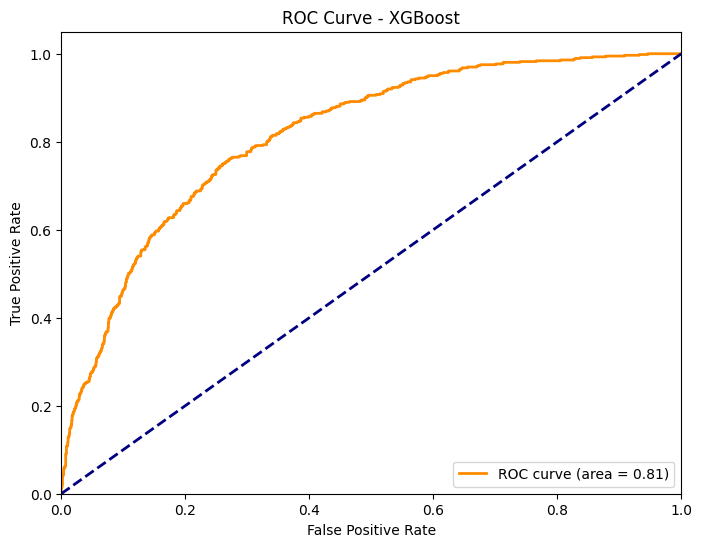


[5/5] Menganalisis hasil dan memberikan rekomendasi...


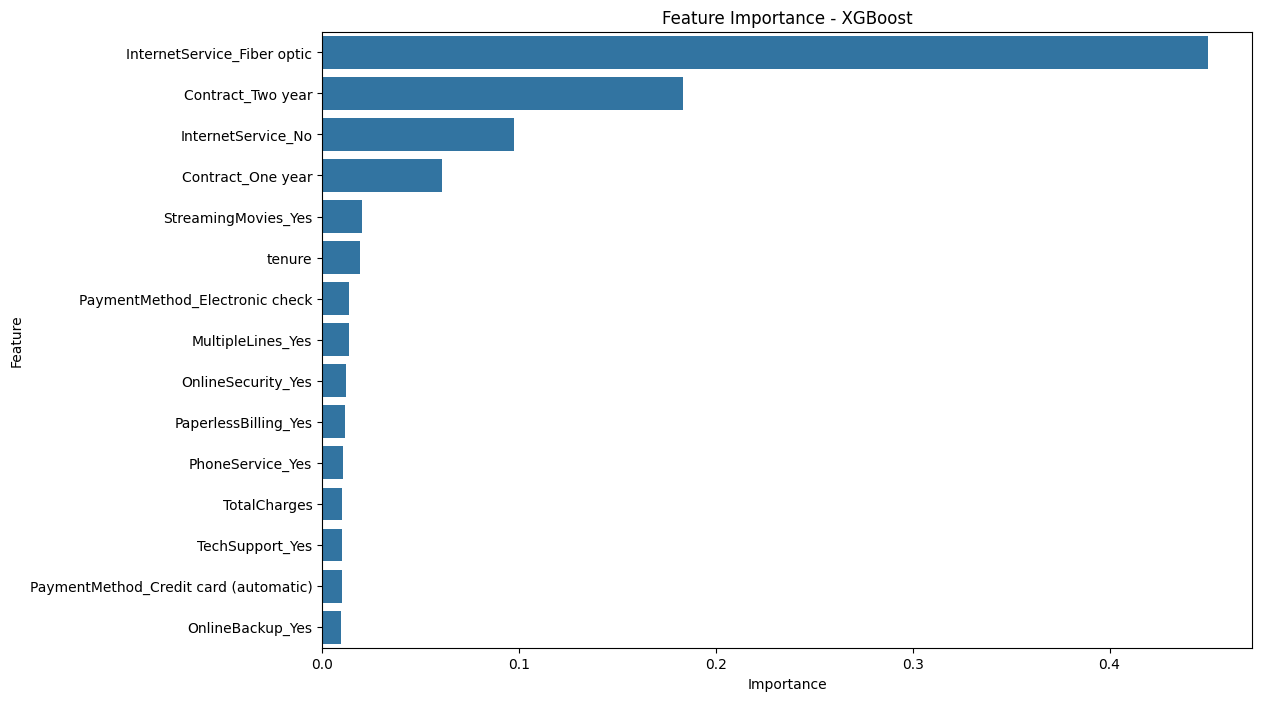


=== Rekomendasi Strategi Retensi Berdasarkan Analisis ===
1. 3. Dorong pelanggan untuk beralih dari kontrak bulanan ke kontrak tahunan dengan memberikan diskon
2. 3. Dorong pelanggan untuk beralih dari kontrak bulanan ke kontrak tahunan dengan memberikan diskon
3. 6. Lakukan program loyalitas untuk meningkatkan engagement pelanggan
4. 7. Identifikasi pelanggan berisiko tinggi secara proaktif dan tawarkan solusi khusus
5. 8. Tingkatkan kualitas layanan pelanggan untuk mengurangi keluhan


In [8]:
# Main Program
def main():
    # 1. Load data
    print("\n[1/5] Memuat dataset...")
    df = load_data()

    # 2. Preprocessing
    print("\n[2/5] Melakukan preprocessing data...")
    df_processed = preprocess_data(df)

    # 3. Visualisasi
    print("\n[3/5] Membuat visualisasi data...")
    visualize_data(df)

    # 4. Split data
    X = df_processed.drop('Churn', axis=1)
    y = df_processed['Churn']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                      random_state=42,
                                                      stratify=y)

    # Scaling fitur numerik
    numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
    scaler = StandardScaler()
    X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
    X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

    # 5. Training dan evaluasi model
    print("\n[4/5] Melatih dan mengevaluasi model...")
    results = train_and_evaluate(X_train, X_test, y_train, y_test)

    # 6. Feature importance dan rekomendasi
    print("\n[5/5] Menganalisis hasil dan memberikan rekomendasi...")
    best_model = results['XGBoost']['model'] # Pilih model terbaik
    feature_imp = plot_feature_importance(best_model, X.columns, 'XGBoost')
    generate_recommendations(feature_imp)

if __name__ == "__main__":
    main()

In [9]:
# 7. Analisis Pelanggan Berisiko Tinggi
def analyze_high_risk_customers(model, X_test, y_test, original_df):
    # Prediksi probabilitas churn
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Tambahkan probabilitas churn ke dataframe
    risk_df = X_test.copy()
    risk_df['Churn_Probability'] = y_pred_proba
    risk_df['Actual_Churn'] = y_test.values

    # Identifikasi pelanggan dengan risiko tinggi (probabilitas > 0.7)
    high_risk = risk_df[risk_df['Churn_Probability'] > 0.7]

    print(f"\n=== Analisis Pelanggan Berisiko Tinggi ===")
    print(f"Jumlah pelanggan berisiko tinggi: {len(high_risk)}")
    print(f"Persentase yang benar-benar churn: {high_risk['Actual_Churn'].mean():.2%}")

    # Gabungkan dengan data asli untuk analisis lebih lanjut
    if 'customerID' in original_df.columns:
        high_risk_with_details = pd.merge(
            high_risk.reset_index(),
            original_df.reset_index(),
            left_on='index',
            right_on='index'
        )

        # Analisis karakteristik pelanggan berisiko tinggi
        print("\nKarakteristik Pelanggan Berisiko Tinggi:")
        print("1. Kontrak:")
        print(high_risk_with_details['Contract'].value_counts(normalize=True))

        print("\n2. Metode Pembayaran:")
        print(high_risk_with_details['PaymentMethod'].value_counts(normalize=True))

        print("\n3. Layanan Tambahan:")
        print("Online Security:", high_risk_with_details['OnlineSecurity'].value_counts(normalize=True))
        print("Tech Support:", high_risk_with_details['TechSupport'].value_counts(normalize=True))

    return high_risk

In [10]:
# 8. Optimasi Model dengan Class Weight (untuk menangani imbalance data)
def optimize_with_class_weight(X_train, y_train, X_test, y_test):
    print("\n=== Optimasi Model dengan Class Weight ===")

    # Hitung class weight
    class_weights = {0: 1, 1: len(y_train[y_train == 0]) / len(y_train[y_train == 1])}
    print(f"Class weights: {class_weights}")

    # Model dengan class weight
    models = {
        'Logistic Regression (weighted)': LogisticRegression(
            max_iter=1000,
            random_state=42,
            class_weight=class_weights
        ),
        'Random Forest (weighted)': RandomForestClassifier(
            random_state=42,
            class_weight=class_weights
        ),
        'XGBoost (weighted)': XGBClassifier(
            random_state=42,
            eval_metric='logloss',
            scale_pos_weight=class_weights[1]
        )
    }

    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        print(f"Recall: {recall_score(y_test, y_pred):.4f}")
        print(f"Precision: {precision_score(y_test, y_pred):.4f}")
        print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")

In [11]:
# 9. Threshold Tuning untuk Optimasi Bisnis
def threshold_tuning(model, X_test, y_test):
    print("\n=== Threshold Tuning ===")

    # Dapatkan probabilitas prediksi
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Coba berbagai threshold
    thresholds = np.arange(0.1, 0.9, 0.05)

    results = []
    for thresh in thresholds:
        y_pred = (y_pred_proba >= thresh).astype(int)
        recall = recall_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        results.append([thresh, recall, precision, f1])

    # Buat dataframe hasil
    results_df = pd.DataFrame(results, columns=['Threshold', 'Recall', 'Precision', 'F1'])

    # Plot hasil
    plt.figure(figsize=(10, 6))
    plt.plot(results_df['Threshold'], results_df['Recall'], label='Recall')
    plt.plot(results_df['Threshold'], results_df['Precision'], label='Precision')
    plt.plot(results_df['Threshold'], results_df['F1'], label='F1 Score')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Threshold Tuning Performance')
    plt.legend()
    plt.show()

    # Temukan threshold optimal (F1 maksimal)
    optimal_idx = np.argmax(results_df['F1'])
    optimal_thresh = results_df.iloc[optimal_idx]['Threshold']

    print(f"\nThreshold optimal: {optimal_thresh:.2f}")
    print(f"Recall pada threshold optimal: {results_df.iloc[optimal_idx]['Recall']:.4f}")
    print(f"Precision pada threshold optimal: {results_df.iloc[optimal_idx]['Precision']:.4f}")
    print(f"F1-Score pada threshold optimal: {results_df.iloc[optimal_idx]['F1']:.4f}")

    return optimal_thresh

In [12]:
# 10. Simulasi Strategi Retensi
def simulate_retention_strategy(high_risk_customers, original_df):
    print("\n=== Simulasi Strategi Retensi ===")

    if 'customerID' in original_df.columns:
        # Gabungkan data
        merged = pd.merge(
            high_risk_customers.reset_index(),
            original_df.reset_index(),
            left_on='index',
            right_on='index'
        )

        # Hitung biaya retensi
        merged['Retention_Cost'] = merged['MonthlyCharges'] * 0.2 # Diskon 20%

        # Hitung potensi revenue yang diselamatkan
        merged['Potential_Saved_Revenue'] = merged['MonthlyCharges'] * 12 # Asumsi 1 tahun

        # Total biaya dan manfaat
        total_cost = merged['Retention_Cost'].sum()
        total_potential = merged[merged['Actual_Churn'] == 1]['Potential_Saved_Revenue'].sum()

        print(f"Total biaya retensi: ${total_cost:,.2f}")
        print(f"Total potensi revenue yang diselamatkan: ${total_potential:,.2f}")
        print(f"ROI: {(total_potential - total_cost)/total_cost:.2%}")

        # Analisis efektivitas berdasarkan kontrak
        if 'Contract' in merged.columns:
            contract_analysis = merged.groupby('Contract').agg({
                'Actual_Churn': 'mean',
                'Retention_Cost': 'sum',
                'Potential_Saved_Revenue': 'sum'
            })
            print("\nAnalisis Berdasarkan Jenis Kontrak:")
            print(contract_analysis)


[1/6] Memuat dataset...

=== Informasi Dataset ===
Jumlah baris: 7043, Jumlah kolom: 21

5 data pertama:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber opt

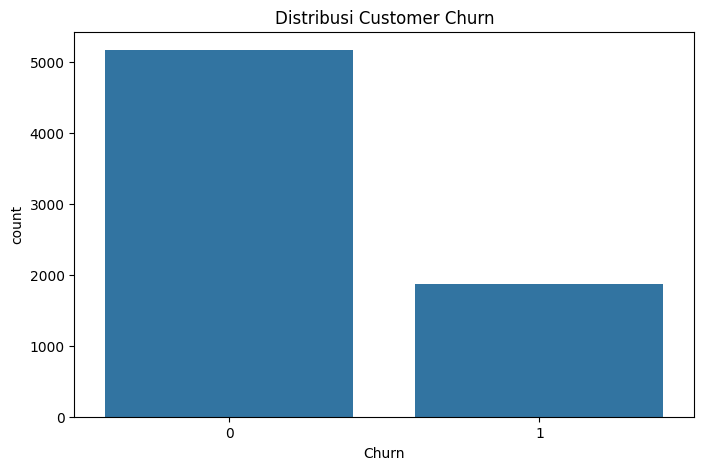

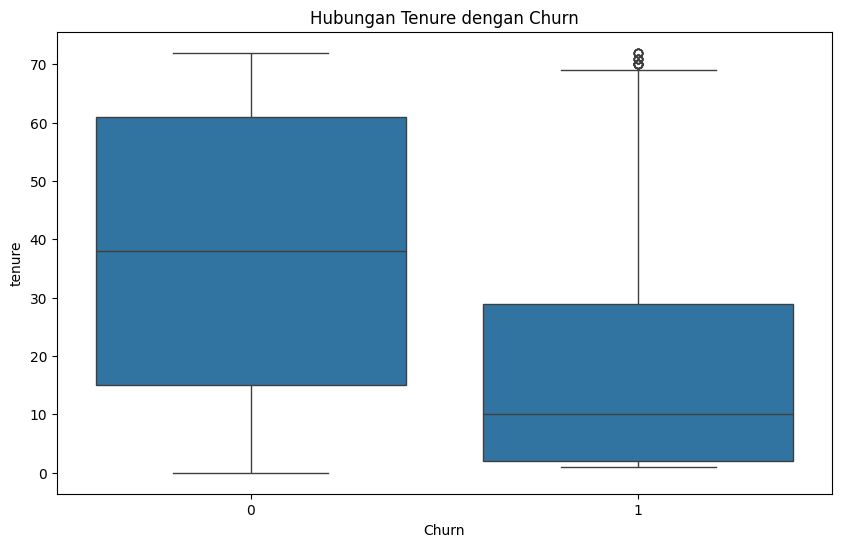

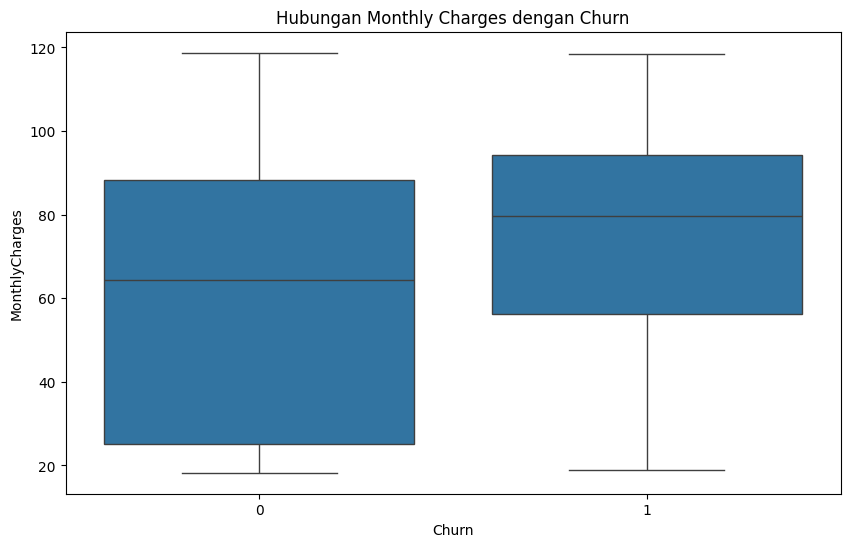


[4/6] Melatih dan mengevaluasi model...

=== Training Logistic Regression ===
Accuracy: 0.8097
Precision: 0.6688
Recall: 0.5615
F1-Score: 0.6105
ROC AUC: 0.8449
CV Mean AUC: 0.8457 (±0.0119)

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1552
           1       0.67      0.56      0.61       561

    accuracy                           0.81      2113
   macro avg       0.76      0.73      0.74      2113
weighted avg       0.80      0.81      0.80      2113



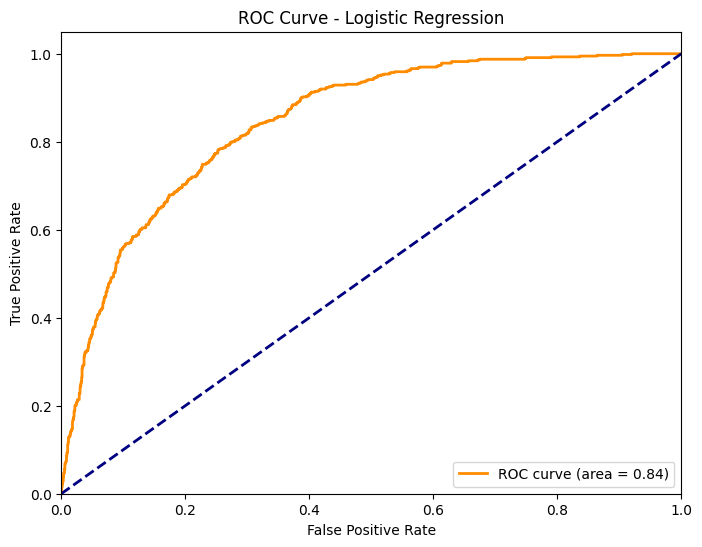


=== Training Random Forest ===
Accuracy: 0.7861
Precision: 0.6236
Recall: 0.4902
F1-Score: 0.5489
ROC AUC: 0.8159
CV Mean AUC: 0.8289 (±0.0145)

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1552
           1       0.62      0.49      0.55       561

    accuracy                           0.79      2113
   macro avg       0.73      0.69      0.70      2113
weighted avg       0.77      0.79      0.78      2113



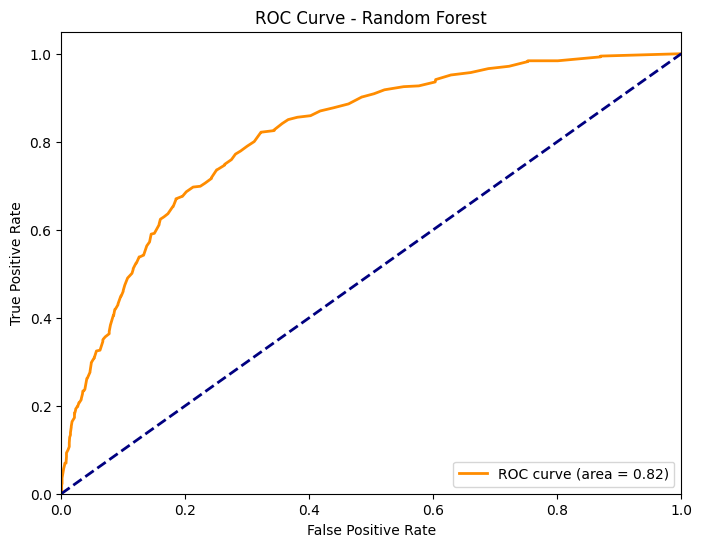


=== Training XGBoost ===
Accuracy: 0.7870
Precision: 0.6168
Recall: 0.5223
F1-Score: 0.5656
ROC AUC: 0.8150
CV Mean AUC: 0.8240 (±0.0179)

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1552
           1       0.62      0.52      0.57       561

    accuracy                           0.79      2113
   macro avg       0.73      0.70      0.71      2113
weighted avg       0.78      0.79      0.78      2113



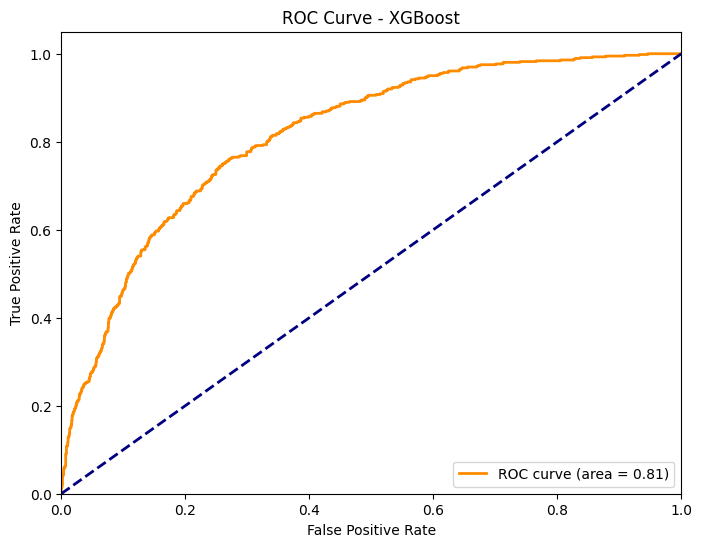


[5/6] Menganalisis pelanggan berisiko tinggi...

=== Analisis Pelanggan Berisiko Tinggi ===
Jumlah pelanggan berisiko tinggi: 283
Persentase yang benar-benar churn: 64.66%

Karakteristik Pelanggan Berisiko Tinggi:
1. Kontrak:
Contract
Month-to-month    0.978799
One year          0.014134
Two year          0.007067
Name: proportion, dtype: float64

2. Metode Pembayaran:
PaymentMethod
Electronic check             0.678445
Mailed check                 0.159011
Bank transfer (automatic)    0.084806
Credit card (automatic)      0.077739
Name: proportion, dtype: float64

3. Layanan Tambahan:
Online Security: OnlineSecurity
No                     0.908127
Yes                    0.060071
No internet service    0.031802
Name: proportion, dtype: float64
Tech Support: TechSupport
No                     0.883392
Yes                    0.084806
No internet service    0.031802
Name: proportion, dtype: float64

[6/6] Menyimpan model terbaik...
Model terbaik telah disimpan sebagai 'best_churn_model.p

In [13]:
# Update Main Program
def main():
    # 1. Load data
    print("\n[1/6] Memuat dataset...")
    df = load_data()
    original_df = df.copy()  # Simpan data asli untuk analisis nanti

    # 2. Preprocessing
    print("\n[2/6] Melakukan preprocessing data...")
    df_processed = preprocess_data(df)

    # 3. Visualisasi
    print("\n[3/6] Membuat visualisasi data...")
    visualize_data(df)

    # 4. Split data
    X = df_processed.drop('Churn', axis=1)
    y = df_processed['Churn']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                      random_state=42,
                                                      stratify=y)

    # Scaling fitur numerik
    numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
    scaler = StandardScaler()
    X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
    X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

    # 5. Training dan evaluasi model
    print("\n[4/6] Melatih dan mengevaluasi model...")
    results = train_and_evaluate(X_train, X_test, y_train, y_test)

    # 6. Analisis pelanggan berisiko tinggi
    print("\n[5/6] Menganalisis pelanggan berisiko tinggi...")
    high_risk_customers = analyze_high_risk_customers(
        results['XGBoost']['model'],
        X_test,
        y_test,
        original_df
    )

    # 7. Simpan model terbaik
    print("\n[6/6] Menyimpan model terbaik...")
    import joblib
    joblib.dump(results['XGBoost']['model'], 'best_churn_model.pkl')
    joblib.dump(scaler, 'scaler.pkl')
    print("Model terbaik telah disimpan sebagai 'best_churn_model.pkl'")

if __name__ == "__main__":
    main()